# Teach a smartcab to drive


## Setup

You need Python 2.7 and pygame for this project: https://www.pygame.org/wiki/GettingStarted
For help with installation, it is best to reach out to the pygame community [help page, Google group, reddit].



In [2]:
# Import what we need, and setup the basic function to run from later.

import math
import string
import sys
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
try:
    cfg = get_ipython().config 
    if cfg['IPKernelApp']['parent_appname'] == 'ipython-notebook':
        print "in notebook"
        from IPython.display import display # Allows the use of display() for DataFrames
        %matplotlib inline    
    else:
        print "in notebook"
        from IPython.display import display # Allows the use of display() for DataFrames
        %matplotlib inline  
except NameError:
    print "in console"
    console=True
sys.path.append("./smartcab/")
from environment import Agent, Environment
from planner import RoutePlanner
from simulator import Simulator

print "Environment ready"

in notebook
Environment ready


In [3]:
# Several of the provided modules output unuseful information during each run. 
#  Here we provide a way to supress that output as needed. 
class outputRedirect():
    def __init__(self):
        self.stout_orig=sys.stdout  # save the current state
    
    def reset(self): #restore to the original state when initiated
        sys.stdout = self.stout_orig
        print "stdout restored!"
        
    def suppress_output(self): # a well formed name for the default of the redirect_output
        self.redirect_output()
        
    def redirect_output(self,f= open(os.devnull, 'w')): # redirect to f, if provided, otherwise to null
        try:
            print "redirecting stdout...."
            sys.stdout = f
        except:
            return "couldn't open destination..."
            self.reset = f
            
redirector=outputRedirect()

print "test a"
redirector.suppress_output()
print "test b"
redirector.reset()
redirector.redirect_output(open(os.devnull, 'w'))
print "test c"
redirector.reset()
print "Redirector ready"

test a
redirecting stdout....
stdout restored!
redirecting stdout....
stdout restored!
Redirector ready


In [72]:

def run(agentType,trials=10, gui=False, deadline=False, delay=0):
    """Run the agent for a finite number of trials."""
    
    # Set up environment and agent
    
    if gui ==False:
        redirector=outputRedirect()
        redirector.suppress_output()
    
    e = Environment()  # create environment (also adds some dummy traffic)
    a = e.create_agent(agentType)  # create agent
    e.set_primary_agent(a, enforce_deadline=deadline)  # specify agent to track
    # NOTE: You can set enforce_deadline=False while debugging to allow longer trials

    # Now simulate it
    sim = Simulator(e, update_delay=delay, display=gui)  # create simulator (uses pygame when display=True, if available)
    # NOTE: To speed up simulation, reduce update_delay and/or set display=False

    sim.run(n_trials=trials)  # run for a specified number of trials
    # NOTE: To quit midway, press Esc or close pygame window, or hit Ctrl+C on the command-line
    
    if gui ==False:
        redirector.reset()    
        
    print "Successfull runs = {}".format(a.goal)
    print "----------------------------------------------------------"
    features= []
    deadlines = []
    for i in range(len(a.features)):
        features.append(pd.DataFrame(a.features[i]).T)
        deadlines.append(a.deadline[i])
        
    rewards=[]
    for i in range(len(a.total_reward)):
        rewards.append(a.total_reward[i])


    try:
        print "Qtable:"
        print "state=light, oncoming, right, left, next_waypoint  / actions=None, forward, left, right"
        for r in a.Qtable:
            print "state={}, {}, {}, {}, {} / action={}".format(r[0],r[1],r[2],r[3],r[4], a.Qtable[r])
    except:
        print "no Qtable"

    return features,deadlines,rewards

print "run ready"

run ready


## Implement a basic driving agent

Implement the basic driving agent, which processes the following inputs at each time step:

Next waypoint location, relative to its current location and heading,
Intersection state (traffic light and presence of cars), and,
Current deadline value (time steps remaining),
And produces some random move/action (None, 'forward', 'left', 'right'). Don’t try to implement the correct strategy! That’s exactly what your agent is supposed to learn.

Run this agent within the simulation environment with enforce_deadline set to False (see run function in agent.py), and observe how it performs. In this mode, the agent is given unlimited time to reach the destination. The current state, action taken by your agent and reward/penalty earned are shown in the simulator.

In your report, mention what you see in the agent’s behavior. Does it eventually make it to the target location?


In [5]:
class RandomAgent(Agent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(RandomAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = [None, 'forward', 'left', 'right']   
        self.goal=0
        self.steps=0
        self.features=[]
        self.deadline=[]
        self.total_reward=[0]

    def reset(self, destination=None):
        self.planner.route_to(destination)
        # TODO: Prepare for a new trip; reset any variables here, if required
        #print"RESET, Final state:\n", self.state
        try:
            if self.deadline[len(self.features)-1] >0: #deadline less than zero
                self.goal+=1 #FIXME - order
                print "PASS! {} steps to goal,Goal reached {} times out of {}!".format(
                                                        self.deadline[len(self.features)-1],self.goal,len(self.features))
            else:
                print "FAIL! {} steps to goal,Goal reached {} times out of {}!".format(
                                                        self.deadline[len(self.features)-1],self.goal,len(self.features))
                pass
        except:
            print "Trial 0 - Goal reached {} times out of {}!".format(self.goal,len(self.features))
            pass
        print "----------------------------------------------------------"
        self.features.append({})
        self.deadline.append(None)
        self.total_reward.append(0)
        self.steps=0

    def update(self, t):
        # Gather inputs
        self.steps+=1
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        #self.deadline[len(self.features)] = self.env.get_deadline(self)
        self.state=inputs
        self.features[len(self.features)-1][self.steps]=inputs
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)

        # TODO: Select action according to your policy
        action = self.availableAction[random.randint(0,3)]    
        
        # Execute action and get reward
        reward = self.env.act(self, action)
        self.lastReward=reward
        # TODO: Learn policy based on state, action, reward
        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward
        #print "LearningAgent.update():deadline{}, inputs{}, action = {}, reward = {}, next_waypoint = {}".format(
        #                                            deadline, inputs, action, reward,self.next_waypoint, )  # [debug]
print "RandomAgent ready"

RandomAgent ready


In [6]:
features,deadlines, rewards=run(agentType=RandomAgent,trials=2, deadline=False) #Example of a random run, with no deadline 

redirecting stdout....
stdout restored!
Successfull runs = 0
----------------------------------------------------------
Qtable:
no Qtable


In [7]:
features,deadlines, rewards=run(agentType=RandomAgent,trials=2, deadline=True) #Example of a random run

redirecting stdout....
stdout restored!
Successfull runs = 0
----------------------------------------------------------
Qtable:
no Qtable


### Random Agent - Discussion:

When we run an agent with a random action policy, we see that it will move about the board with no pattern, and will eventually reach the destination. If we allow the use of deadlines, we see that the agent rarely reaches the destination in time, although it may still occur.

---------------------------------------------------------------


## Identify and update state

Identify a set of states that you think are appropriate for modeling the driving agent. The main source of state variables are current inputs, but not all of them may be worth representing. Also, you can choose to explicitly define states, or use some combination (vector) of inputs as an implicit state.

At each time step, process the inputs and update the current state. Run it again (and as often as you need) to observe how the reported state changes through the run.

In [8]:
class StateAgent(RandomAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(StateAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = [None, 'forward', 'left', 'right']   
        self.next_waypoint   = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.total_reward=[0]

        
    def update(self, t):
        # Gather inputs
        self.steps+=1
        
        self.lastWaypoint = self.next_waypoint
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        
        deadline = self.env.get_deadline(self)
        
        # TODO: Update state
        
        inputs['next_waypoint']=self.next_waypoint
        self.state= inputs    
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)
        self.features[len(self.features)-1][self.steps]=inputs
        # TODO: Select action according to your policy

        action = self.availableAction[random.randint(0,3)]    
    
        # Execute action and get reward
        reward = self.env.act(self, action)
        # TODO: Learn policy based on state, action, reward

        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward

        #print "LearningAgent.update(): self.state{}, action = {}, reward = {}, next_waypoint = {}".format(
        #                                        self.state, action, reward,self.next_waypoint, )  # [debug]
print "StateAgent Ready"

StateAgent Ready


In [64]:
# run the trials for the state


stateFeatures,StateDeadlines,StateRewards=run(agentType=StateAgent,trials=25)

print "Random Agent done"

redirecting stdout....
stdout restored!
Successfull runs = 5
----------------------------------------------------------
Qtable:
state=light, oncoming, right, left, next_waypoint  - actions=None, forward, left, right
no Qtable
Random Agent done


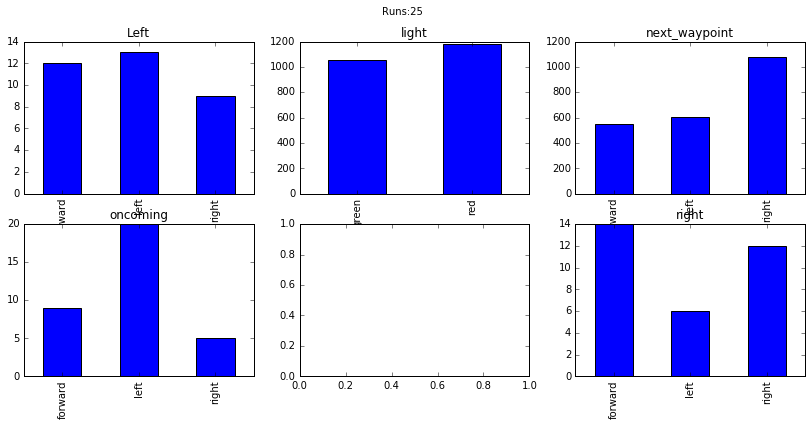

In [51]:
# display the feedback from the prior run
def statsFromRun(stateFeatures):
    left=pd.Series()
    light=pd.Series()
    next_waypoint=pd.Series()
    oncoming=pd.Series()
    right=pd.Series()
    for f in stateFeatures:
        left= left.add(pd.value_counts(f.left.ravel()), fill_value=0)
        light= light.add(pd.value_counts(f.light.ravel()), fill_value=0)
        next_waypoint= next_waypoint.add(pd.value_counts(f.next_waypoint.ravel()), fill_value=0)
        oncoming= oncoming.add(pd.value_counts(f.oncoming.ravel()), fill_value=0)
        right= right.add(pd.value_counts(f.right.ravel()), fill_value=0)

    fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(14,6))
    fig.suptitle( "Runs:{}".format(len(stateFeatures)))

    left.plot(kind='bar', title="Left",ax=axes[0,0])
    light.plot(kind='bar', title="light",ax=axes[0,1])
    next_waypoint.plot(kind='bar', title="next_waypoint",ax=axes[0,2])
    oncoming.plot(kind='bar', title="oncoming",ax=axes[1,0])
    right.plot(kind='bar', title="right",ax=axes[1,2])
    plt.show()
    plt.close()
    
statsFromRun(stateFeatures)

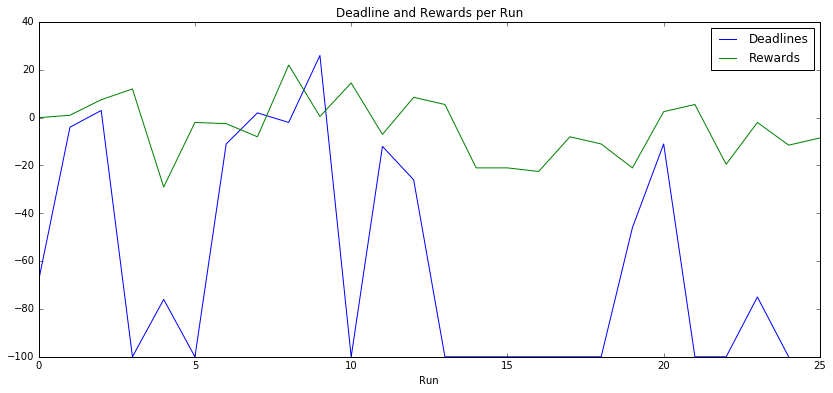

In [55]:
def scorePerRun(DL,RW):
    plt.figure(figsize=(14,6))
    plt.plot(DL,label="Deadlines")
    plt.plot(RW,label="Rewards")
    plt.xlabel('Run')
    plt.legend()
    plt.title("Deadline and Rewards per Run")
    plt.show()
    plt.close()
    
scorePerRun(StateDeadlines,StateRewards)

### Identify and update state - Discussion.
When we sense our environment, we perceive 5 variables, with several possible states These include: left, light, next_waypoint, oncoming, and right. We can see right away that light and next_waypoint contains new information at every poll, while the others usually have no value. 

It's not readily apparent that the direction of travel information of the other cars (described by left/right/oncoming) is relevant to our agent. A case could be made to remove the direction information, and only retain information about another car being present at the light. This would have the benefit of reducing the number of possible states, increasing the speed of the agent. This may be a valuable approach in resource constrained environments. 

The downside is that the agent may pick an action that causes a longer trip. Early in the learning phase, it could also pick an action incorrectly. For instance, by proceeding through a light when the opposite car is turning left. In this case, it may have previously seen a positive reward for moving through the light, because the opposite car was not turning. This time through, it will recieve a negative reward, and in the future when a car is at the oncoming light, it will always wait till the intersection is clear.

In the interest of correctness, we will choose to use the state as returned from the sensor, with the addition of the next_waypoint.

While I have tracked the deadline, it is not apparent that it will provide useful information to the agent. It is useful to see note that the agent does not see any usefull increase in the deadline value yet. We may expect this to adapt as we implement learning.

---------------------------------------------------------------

## Implement Q-Learning

Implement the Q-Learning algorithm by initializing and updating a table/mapping of Q-values at each time step. Now, instead of randomly selecting an action, pick the best action available from the current state based on Q-values, and return that.

Each action generates a corresponding numeric reward or penalty (which may be zero). Your agent should take this into account when updating Q-values. Run it again, and observe the behavior.

What changes do you notice in the agent’s behavior?



In [65]:
class BasicLearningAgent(RandomAgent):
    """An agent that learns to drive in the smartcab world."""

    def __init__(self, env):
        super(BasicLearningAgent, self).__init__(env)  # sets self.env = env, state = None, next_waypoint = None
        self.color = 'red'  # override color
        self.planner = RoutePlanner(self.env, self)  # simple route planner to get next_waypoint
        # TODO: Initialize any additional variables here
        self.availableAction = [None, 'forward', 'left', 'right']   
        self.next_waypoint   = None
        self.goal=0
        self.steps=0
        self.features=[]
        self.Qtable={}
        self.epsilon=0.1
        self.gamma=0
        self.last_state = None
        self.last_action = None
        self.total_reward=[0]

        
    def update(self, t):
        # Gather inputs
        self.steps+=1
        
        self.next_waypoint = self.planner.next_waypoint()  # from route planner, also displayed by simulator
        inputs = self.env.sense(self)
        
        deadline = self.env.get_deadline(self)
        # TODO: Update state
        inputs['next_waypoint']=self.next_waypoint
        self.state = (inputs['light'], inputs['oncoming'], inputs['right'], inputs['left'],inputs['next_waypoint'])
        self.deadline[len(self.deadline)-1] = self.env.get_deadline(self)
        self.features[len(self.features)-1][self.steps]=inputs
        # TODO: Select action according to your policy

        action = self.availableAction[random.randint(0,3)]    #take a random action
        
        # 1-epsilon % of time, refer to the q-table for an action. take the max value from the available actions
        if self.epsilon < random.random() and  self.Qtable.has_key(self.state): 
            action=self.availableAction[self.Qtable[self.state].index(max(self.Qtable[self.state]))]
                                                    
        # Execute action and get reward
        reward = self.env.act(self, action)
        # TODO: Learn policy based on state, action, reward
        if self.Qtable.has_key(self.state):
            self.Qtable[self.state][self.availableAction.index(action)]=reward
        else:
            self.Qtable[self.state]=[0,0,0,0]
            self.Qtable[self.state][self.availableAction.index(action)]=reward
        
        self.last_state = self.state
        self.last_action = action
        self.total_reward[len(self.total_reward)-1] =self.total_reward[len(self.total_reward)-1]+reward

        #print "LearningAgent.update(): self.state{}, action = {}, reward = {}, next_waypoint = {}".format(
        #                                        self.state, action, reward,self.next_waypoint, )  # [debug]
print "BasicLearningAgent Ready"

BasicLearningAgent Ready


In [66]:
# run the trials for the Basic Q learning agent
basicLearnFeatures,BLdeadlines,BLrewards=run(agentType=BasicLearningAgent,trials=100, deadline=True) 

print "Basic Q Learning Agent done"

redirecting stdout....
stdout restored!
Successfull runs = 92
----------------------------------------------------------
Qtable:
state=light, oncoming, right, left, next_waypoint  - actions=None, forward, left, right
state=green, None,forward,None,forward [0, 2.0, 0, 0]
state=green, None,None,right,forward [0.0, 0, 0, 0]
state=red, left,None,None,left [0, 0, 0, -0.5]
state=green, right,None,None,right [0.0, 0, 0, 0]
state=red, None,None,left,forward [0, 0, -1.0, 0]
state=red, forward,None,None,forward [0.0, 0, 0, 0]
state=green, None,None,None,left [0.0, -0.5, 12.0, -0.5]
state=red, left,None,None,forward [0.0, -1.0, -1.0, -0.5]
state=green, None,None,left,forward [0, 2.0, 0, 0]
state=red, None,left,None,forward [0.0, 0, 0, 0]
state=red, left,None,None,right [0.0, 0, 0, 0]
state=green, None,right,None,forward [0, 12.0, 0, 0]
state=green, right,None,None,forward [0.0, 0, 0, 0]
state=red, right,None,None,left [0, 0, -1.0, 0]
state=red, None,None,None,left [0.0, -1.0, -1.0, -0.5]
state=re

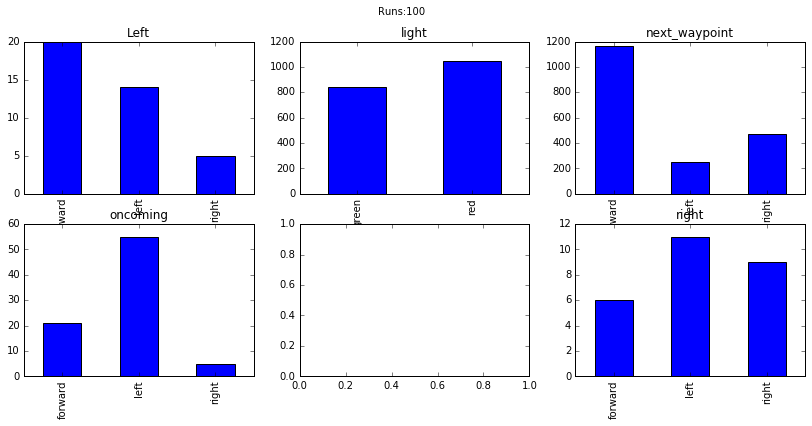

In [58]:
statsFromRun(basicLearnFeatures)

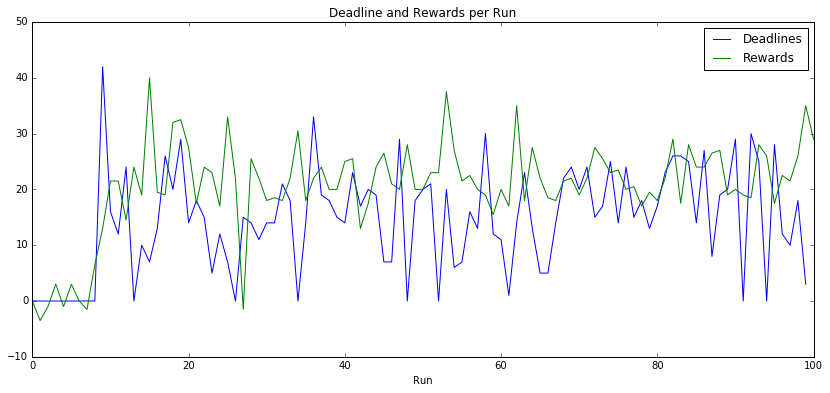

In [59]:
scorePerRun(BLdeadlines,BLrewards)

### Implement Q-Learning - Discussion
With a basic Qlearning algorithm, we note that the agent quickly learns a set of rules that allow the agent to move toward the objective. Generarlly speaking the agent, is moving to the destination, but may not always make optimal choices. With this version of Q-Learning, we don't see a large continued increase in the agent speed toward the destination.

---------------------------------------------------------------

## Enhance the driving agent

Apply the reinforcement learning techniques you have learnt, and tweak the parameters (e.g. learning rate, discount factor, action selection method, etc.), to improve the performance of your agent. Your goal is to get it to a point so that within 100 trials, the agent is able to learn a feasible policy - i.e. reach the destination within the allotted time, with net reward remaining positive.

Report what changes you made to your basic implementation of Q-Learning to achieve the final version of the agent. How well does it perform?

Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties?

## Enhance the driving agent - Discussion


---------------------------------------------------------------

running....
redirecting stdout....
stdout restored!
Successfull runs = 22
----------------------------------------------------------
Qtable:
state=light, oncoming, right, left, next_waypoint  / actions=None, forward, left, right
state=red, None, None, None, right / action=[0.0, 0, -1.0, 2.0]
state=red, None, None, None, forward / action=[0.0, -1.0, -1.0, -0.5]
state=red, None, None, None, left / action=[0.0, -1.0, -1.0, -0.5]
state=green, right, None, None, forward / action=[0, 0, 0, -0.5]
state=green, None, None, None, forward / action=[0.0, 12.0, -0.5, -0.5]
state=green, None, left, None, right / action=[0, 0, 0, 2.0]
state=red, forward, None, None, forward / action=[0, 0, 0, -0.5]
state=green, None, None, None, left / action=[0.0, -0.5, 2.0, 0]
state=red, None, None, forward, forward / action=[0, 0, -1.0, 0]
state=red, left, None, None, right / action=[0.0, 0, 0, 0]
state=green, None, forward, None, forward / action=[0, 0, 0, -0.5]
state=red, None, forward, None, left / action=[0.0,

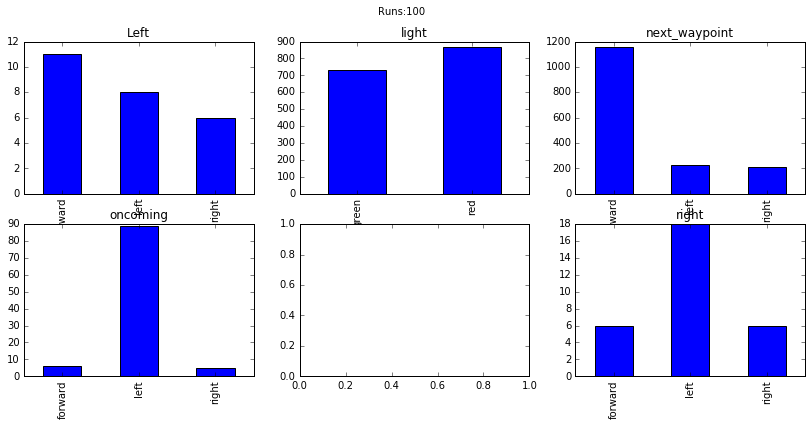

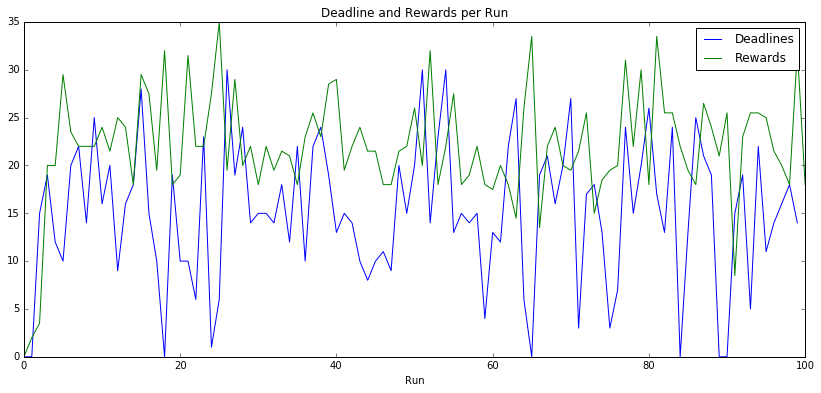

In [73]:
if __name__ == '__main__':
    print  "running...."
    basicLearnFeatures,BLdeadlines,BLrewards==run(agentType=BasicLearningAgent,trials=25, gui=False, delay=.00)
    statsFromRun(basicLearnFeatures)
    scorePerRun(BLdeadlines,BLrewards)

#EOF